# **About Dataset**

## **Context**

The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

## **Content**

It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:



1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

## Acknowledgements
Source: UCI

In [3]:
import pandas as pd
import numpy as np
#ignor warning
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("german_credit_data.csv", index_col=0)
df.head()



,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
df["Risk"] = (df["Risk"] == "bad").astype(int)

X = df.drop(columns="Risk")
y = df["Risk"]


In [5]:
cat_cols = X.select_dtypes("object").columns

for c in cat_cols:
    X[c] = X[c].astype("category").cat.codes

In [6]:
from sklearn.model_selection import train_test_split


Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(Xtr, ytr, categorical_feature=list(cat_cols))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 241, number of negative: 559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301250 -> initscore=-0.841353
[LightGBM] [Info] Start training from score -0.841353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMClassifier()

In [8]:
from sklearn.metrics import roc_auc_score

def auc(model, X, y):
    return roc_auc_score(y, model.predict_proba(X)[:,1])

In [9]:
base_score = auc(model, Xte, yte)
base_score

0.8008174059382137

In [10]:
all_importances = []
n_permutations = 100


for col in Xte.columns:
  current = []
  for i in range(n_permutations):
    # run permutation of feature col
    X_perm = Xte.copy()
    X_perm[col] = np.random.permutation(X_perm[col].values)
    # run the prediction on the new sample
    pred = model.predict_proba(X_perm)[:,1]
    # calculate the auc
    score = roc_auc_score(yte, pred)
    # compute the difference and add it to my list
    current.append(base_score - score)
  # print column name
  print("Column name: ", col)
  print("Col auc values: ", current)
  all_importances.append(current)

Column name:  Age
Col auc values:  [0.007933645870897954, -0.012621709340065013, 0.005890131025363621, -0.01646832551989419, 0.012381295828825523, 0.01286212285130428, 0.011539848539487862, 0.01791080658733024, 0.011419641783868228, 0.045438153624233646, 0.01983411467724483, -0.015867291741795908, 0.01117922827262885, -0.014545017429979601, -0.011660055295107608, 0.02404135112393324, 0.03101334294987368, 0.004567856713547203, 0.02488279841327079, 0.02235845654525781, -0.01706935929799258, -0.010097367472051921, -0.005769924269743876, -0.020555355210962856, 0.016348118764274444, 0.006851785070320915, 0.05902151700925595, 0.03377809832912604, -0.005649717514124242, 0.008534679648996235, 0.07320591417237632, 0.05144849140521712, 0.004808270224786582, 0.00949633369395353, 0.02933044837119847, 0.016828945786753202, 0.05060704411587924, 0.029210241615578725, 0.030652722683014777, 0.0669551628801538, 0.02957086188243785, 0.012261089073205889, 0.02824858757062154, 0.047962495492246626, 0.01682

Column name:  Saving accounts
Col auc values:  [0.035100372640942346, 0.023560524101454594, 0.02259887005649719, 0.020915975477821758, 0.03738430099771606, 0.022959490323356202, 0.01815122009856951, 0.02175742276715953, 0.03017189566053602, 0.012741916095684647, 0.03750450775333569, 0.026084865969467463, 0.023320110590215104, 0.029691068638057483, 0.015987498497415542, 0.010578194494530568, 0.03185479023921145, 0.02428176463517251, 0.02764755379252315, 0.017189566053612215, 0.04700084144728922, 0.032576030772929476, 0.023680730857074228, 0.03149416997235244, 0.028849621348719823, 0.014424810674359967, 0.024401971390792254, 0.021156388989061137, 0.031734583483591705, 0.04087029691068633, 0.024522178146411777, 0.025123211924510058, 0.02211804303401843, 0.03834595504267335, 0.01791080658733013, 0.03522057939656198, 0.035340786152181614, 0.00528909724726534, 0.016348118764274555, 0.03546099290780136, 0.04411587931241734, 0.025243418680129914, 0.034499338862844064, 0.04026926313258805, 0.02

Column name:  Purpose
Col auc values:  [0.007212405337180039, 0.015987498497415542, 0.02824858757062143, -0.014545017429979601, 0.018271426854189143, 0.008174059382137222, 0.005529510758504608, 0.014665224185599235, 0.0026445486236326143, -0.013823776896261575, 0.006010337780983366, -0.0030051688904917384, 0.015266257963697516, 0.013102536362543549, -0.0033657891573506404, 0.012982329606923804, -0.0009616540449574051, 0.013583363385022196, 0.014905637696838614, 0.009015506671474993, 0.005289097247265229, 0.014184397163120699, 0.02091597547782187, -0.005168890491645595, 0.008053852626517699, 0.02235845654525792, 0.009616540449573274, 0.014424810674359856, 0.0026445486236326143, 0.00697199182594066, 0.022719076812116934, 0.010818608005769836, 0.00949633369395353, 0.017189566053612215, 0.03017189566053613, 0.009255920182714261, 0.014304603918740222, -0.0036062026685899085, 0.005890131025363621, 0.006731578314701281, 0.007693232359658686, 0.03317706455102787, 0.013823776896261575, -0.01646

In [11]:
# build perm_importance_df dataframe the contains one column per feature and one per permutation
perm_importance_df = pd.DataFrame(all_importances)
perm_importance_df = perm_importance_df.T
perm_importance_df.columns = Xte.columns

In [12]:
mean_importances = perm_importance_df.mean().sort_values(ascending=False)
perm_importance_df_ordered = perm_importance_df[mean_importances.index]

print("Features ordered by mean importance:\n", mean_importances)

Features ordered by mean importance:
 Checking account    0.111754
Duration            0.109674
Credit amount       0.078957
Saving accounts     0.027230
Age                 0.012444
Purpose             0.009286
Job                 0.002926
Sex                 0.001956
Housing            -0.004321
dtype: float64


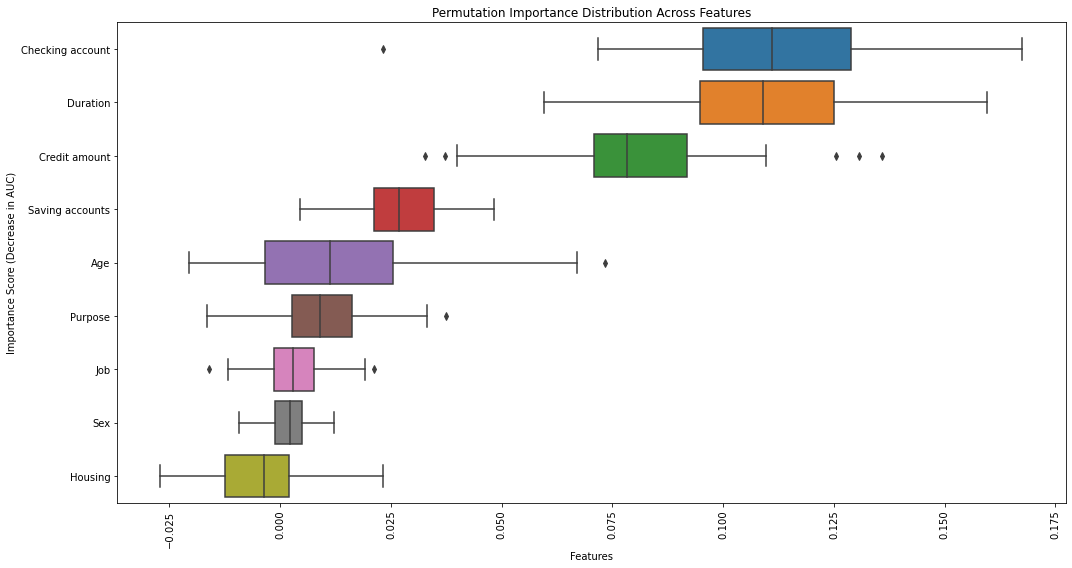

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.boxplot(data=perm_importance_df_ordered, orient="h")
plt.xticks(rotation=90)
plt.title('Permutation Importance Distribution Across Features')
plt.ylabel('Importance Score (Decrease in AUC)')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

In [14]:
# let's calculate the ICE for teh feature Duration and for all samples of the test dataset
# you should first split duration distribution in 30 bins
# for every bins value calculate the prediction for all test sample
# plot all the curves in a lines plot

def ice_plot(feature_name, n_bins):
  bins = np.linspace(Xte[feature_name].min(), Xte[feature_name].max(), n_bins)
  ice_curves = []

  #start with the samples loop
  for i in range(len(Xte)):
    curve =  []
    # now the loop on the bins
    for bin in bins:
      # duplicate only the line i
      xi_bin = Xte.iloc[[i]]
      xi_bin[feature_name] = bin
      pred = model.predict_proba(xi_bin)[:,1]
      curve.append(pred[0])
    # we want to center the ICE curve and make it starts at 0
    curve = np.array(curve) - curve[0]
    ice_curves.append(curve)
    # plot all curves on the same graph
  plt.figure(figsize=(15, 8))
  for curve in ice_curves:
    plt.plot(bins, curve, color ="gray", alpha = 0.2)
    plt.xlabel(feature_name)
    plt.ylabel("Prediction")
    plt.title("ICE for " + feature_name)
  plt.show()

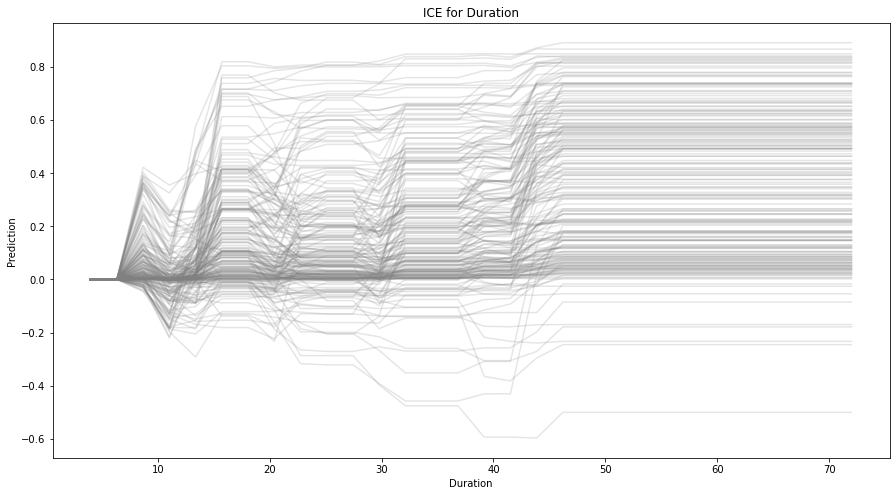

In [15]:
ice_plot("Duration", 30)

In [16]:
def PDP_curve(feature_name, n_bins):
  PDP_curve = []

  bins = np.linspace(Xte[feature_name].min(), Xte[feature_name].max(), n_bins)
  #start with bin
  for bin in bins:
    bin_values = []
    # instead of looping on the samples, we can copy whole dataset and change
    # and change bin for all lines
    x_bin = Xte.copy()
    x_bin[feature_name] = bin
    pred = model.predict_proba(x_bin)[:,1]
    PDP_curve.append(np.mean(pred))
    #plt the PDP
  plt.figure(figsize=(12, 6))
  plt.plot(bins, PDP_curve, color ="gray")
  plt.xlabel(feature_name)
  plt.ylabel("Prediction")
  plt.title("PDP for " + feature_name)

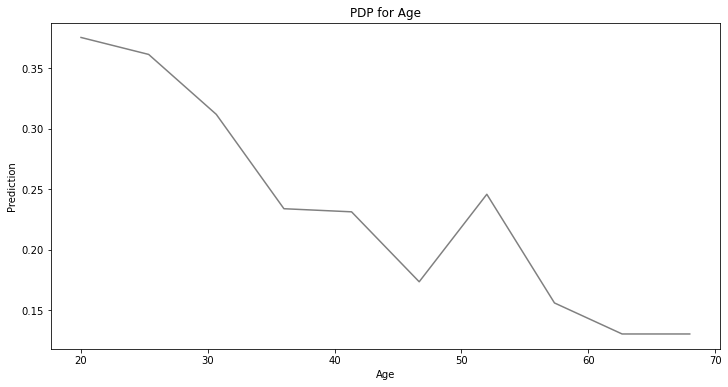

In [17]:
PDP_curve("Age", 10)

In [25]:
# LIME

import lime
import random

explainer = lime.lime_tabular.LimeTabularExplainer(Xtr.to_numpy(), 
                                              mode="regression", 
                                              feature_names= list(Xtr.columns))

In [33]:
y_train_predict = pd.DataFrame(model.predict(Xtr))

In [39]:
Y = ytr.copy()
Y["Prediction"] = y_train_predict.to_numpy()
Y.columns = ["Real", "Predict"]
#Y = Y.sort_index()
#Y["Id"] = Y.index
#Y["Delta"] = Y["Real"] - Y["Predict"]
Y = Y.head(50)
plt.rcParams["figure.figsize"] = (50, 10)
#Y["Real"].plot(color="#FF0000") # Red line
#Y["Predict"].plot(color="#0000FF") # Blue line

In [42]:
def xai_display_for_value(idx):
    print("----------------------------------------------------")
    print("Index: ", idx)
    print("Scaled Prediction: ", yte.iloc[idx])
    print("Scaled Actual:     ", ytr.iloc[idx])
    print("Predicted value: ", yte.iloc[idx])
    print("Real value: ", ytr.iloc[idx])
    print("Delta (%): ", (ytr.iloc[idx] - yte.iloc[idx]) * 100 / ytr.iloc[idx])
    explanation = explainer.explain_instance(Xtr.iloc[idx], model.predict, num_features=len(list(Xtr.columns)))

    explanation.show_in_notebook(show_table=True)
    return explanation

In [43]:
expl = xai_display_for_value(1)
expl.as_list()

----------------------------------------------------
Index:  1
Scaled Prediction:  0
Scaled Actual:      1
Predicted value:  0
Real value:  1
Delta (%):  100.0


[('Job <= 2.00', 0.23565559737269767),
 ('Housing > 1.00', -0.19048103107395575),
 ('27.00 < Age <= 33.00', 0.17202859405907509),
 ('18.00 < Duration <= 24.00', 0.16686269548086685),
 ('1380.00 < Credit amount <= 2333.00', -0.06367990133064727),
 ('1.00 < Purpose <= 3.00', 0.03577531424976389),
 ('Saving accounts <= 0.00', 0.03005359969122568),
 ('Checking account > 1.00', 0.029791800060095613),
 ('0.00 < Sex <= 1.00', 0.019602208192780194)]